# Meta-Labeling Experiments: A Step-by-Step Guide

## Introduction

This notebook recreates the meta-labeling experiments from Hudson & Thames' research in a beginner-friendly manner. Meta-labeling is a machine learning technique that sits on top of a primary trading strategy to improve performance by filtering out false positive signals.

**Key Concepts:**
- **Primary Model**: Generates trading signals (buy/sell/hold)
- **Triple Barrier Method**: Advanced labeling technique that accounts for stop-loss, take-profit, and time-based exits
- **Meta-Labeling**: Secondary ML model that decides whether to act on primary model signals
- **Goal**: Improve Sharpe ratio, reduce drawdown, and increase precision

## Setup and Dependencies

In [1]:
import sys
sys.path.append("..")  # Adjust based on your directory structure

%load_ext autoreload
%load_ext line_profiler
%autoreload 3 -p

# %aimport afml

In [2]:
import warnings
import winsound
from datetime import timedelta, datetime as dt
from pprint import pprint
from pathlib import Path

import pandas_ta as ta
import talib
import matplotlib.pyplot as plt
import MetaTrader5 as mt5
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from feature_engine.selection import DropCorrelatedFeatures

from afml.backtest_statistics.reporting import (
    create_classification_report_image,
    meta_labelling_reports,
)

from afml.data_structures.bars import *
from afml.features import get_time_features, get_fractal_features
from afml.filters import cusum_filter
from afml.labeling import (
    add_vertical_barrier,
    calculate_label_metrics,
    fixed_time_horizon,
    get_bins,
    get_bins_from_trend,
    get_events,
    triple_barrier_labels,
    get_trend_scanning_meta_labels,

)
from afml.strategies import (
    BaseStrategy,
    BollingerMeanReversionStrategy,
    MovingAverageCrossoverStrategy,
    TripleBarrierEvaluator,
    create_bollinger_features,
    get_entries,
)
from afml.util import (
    COMMODITIES,
    CLEAN_DATA_PATH,
    CRYPTO,
    DATA_PATH,
    FX_MAJORS,
    PERCENTILES,
    UTC,
    DataFrameFormatter,
    get_daily_vol,
    value_counts_data,
)
from afml.mt5.get_data import (
    get_ticks,
    load_tick_data,
    login_mt5,
    save_data_to_parquet,
    verify_or_create_account_info,
)
from notebooks.training import train_meta_model, compare_roc_curves, meta_labelling_classification_reports

warnings.filterwarnings("ignore")
plt.style.use("dark_background")


In [3]:
# from afml.cache import clear_afml_cache


# clear_afml_cache()

## 1. Data Preparation

In [4]:
account = "FundedNext_STLR2_6K"
# account = login_mt5(account="FundedNext_STLR2_6K")
symbol = "EURUSD"
columns = ['bid', 'ask']
tick_bar_dict = {"M1": 50, "M5": 200, "M15": 700, "M30": 1000, "H1": 3000}
tick_df = None

start_date, end_date = "2018-01-01", "2024-12-31"
sample_start, sample_end = start_date, "2021-12-31"
oos_start = pd.Timestamp(sample_end) + timedelta(days=1) # Out-of-sample start date


def get_data(symbol, timeframe, dirpath="../data"):
    """Returns time-bars and tick-bars for timeframe"""
    global tick_df
    timeframe = timeframe.title()
    directory = Path(dirpath)
    tick_bar_size = tick_bar_dict[timeframe]
    fname = Path(dirpath, f"{symbol}_{timeframe}_time_{start_date}-{end_date}.parq")
    fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
    time_bars, tick_bars = (None, None)

    # --- Construct the search pattern ---
    # The '*' is a wildcard that matches any sequence of characters
    search_pattern = f"{symbol}_{timeframe}_*"

    # --- Find the files ---
    # glob() returns a generator, so you can iterate over it
    found_files = directory.glob(search_pattern)

    # --- Print the results ---
    for file in found_files:
        if fname == file:
            time_bars = pd.read_parquet(fname)
            print("Loaded", file.name)
        elif fname1 == file:
            tick_bars = pd.read_parquet(fname1)
            print("Loaded", file.name)
        
    if any(x is None for x in (time_bars, tick_bars)):
        try:
            tick_df = load_tick_data(CLEAN_DATA_PATH, symbol, start_date, end_date, account, columns)
        except FileNotFoundError:
            save_data_to_parquet(CLEAN_DATA_PATH, symbol, start_date, end_date, account)
        if time_bars is None:
            time_bars = make_bars(tick_df, bar_type="time", timeframe=timeframe, price="bid_ask", verbose=True)
            time_bars.to_parquet(fname)
        if tick_bars is None:
            tick_bar_size = calculate_ticks_per_period(tick_df, timeframe)
            tick_bar_dict[timeframe] = tick_bar_size
            tick_bars = make_bars(tick_df, bar_type="tick", bar_size=tick_bar_size, price="bid_ask", verbose=True)
            fname1 = Path(dirpath, f"{symbol}_{timeframe}_tick-{tick_bar_size}_{start_date}-{end_date}.parq")
            tick_bars.to_parquet(fname1)

    return time_bars, tick_bars

## 2. Bollinger Band Strategy

In [5]:
timeframe = "M5"
tick_bar_size = tick_bar_dict[timeframe]
bb_time_bars, bb_tick_bars = get_data(symbol, timeframe)
bar_size = f"tick-{bb_tick_bars.tick_volume.iloc[0]}"
bb_df = bb_time_bars.loc[sample_start : sample_end]
bb_df0 = bb_tick_bars.loc[sample_start : sample_end]

Loaded EURUSD_M5_tick-200_2018-01-01-2024-12-31.parq
Loaded EURUSD_M5_time_2018-01-01-2024-12-31.parq


### Feature Engineering

In [6]:
bb_period, bb_std = 20, 1.5 # Bollinger Band parameters
bb_strategy = BollingerMeanReversionStrategy(window=bb_period, num_std=bb_std)

# No shifting b/c mean-reversion seems to benefit from contemporaneous information
lookback = 10
bb_feat = create_bollinger_features(bb_df, lookback, bb_period, bb_std)
bb_feat.info()

# trend_feat = get_bins_from_trend(bb_df.close, span=(5, bb_period), volatility_threshold=0.1, lookforward=False)
# bb_feat = bb_feat.join(trend_feat[['window', 'slope', 't_value', 'rsquared']])

# bb_feat = bb_feat.shift() # Avoid look-ahead bias


2025-08-31 00:56:35.387 | INFO     | afml.features.moving_averages:calculate_ma_differences:35 - 
Dropped features with correlation > 0.8: 
	['sma_diff_10_200', 'sma_diff_10_50', 'sma_diff_20_100', 'sma_diff_20_200', 'sma_diff_20_50', 'sma_diff_50_100', 'sma_diff_50_200', 'sma_diff_5_100', 'sma_diff_5_20', 'sma_diff_5_200', 'sma_diff_5_50']
Kept features: 
	['sma_diff_5_10', 'sma_diff_10_20', 'sma_diff_10_100', 'sma_diff_100_200']
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 295657 entries, 2018-01-01 23:05:00 to 2021-12-31 23:00:00
Data columns (total 48 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rel_spread        295657 non-null  float32
 1   bb_bandwidth      295638 non-null  float32
 2   bb_percentage     295638 non-null  float64
 3   returns           295656 non-null  float32
 4   returns_5         295652 non-null  float32
 5   returns_10        295647 non-null  float32
 6   returns_1_lag_1   295655 non-nu

In [50]:
target_vol_params = dict(days=1, lookback=100)
tb_evaluator = TripleBarrierEvaluator(
    bb_strategy, bb_df, target_vol_params,
    target_vol_multiplier=1,
    filter_events=True,
    vertical_barrier_zero=True,
    on_crossover=True,
    )
pt_barrier, sl_barrier, time_horizon = (2, 1, 20)

2025-08-31 01:09:29.333 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-31 01:09:29.483 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 7,834 trade events generated by CUSUM filter.


### Fixed-Time Horizon Method

In [8]:
bb_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
bb_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_fh)

### Triple-Barrier Method

In [9]:
bb_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
bb_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(bb_events_tbl)

In [10]:
print(f"Bollinger_w{bb_period}_std{bb_std}: \n")

bb_metrics_df = pd.DataFrame({
    "fixed_horizon": bb_events_fh_metrics,
    "triple_barrier": bb_events_tbl_metrics,
    })
bb_metrics_df

Bollinger_w20_std1.5: 



,fixed_horizon,triple_barrier
total_return,0.724101,0.442506
annualized_return,0.146205,0.096128
volatility,0.405758,0.377989
downside_volatility,0.275666,0.227723
sharpe_ratio,12.887154,9.347379
sortino_ratio,18.968848,15.515375
var_95,-0.002226,-0.002
cvar_95,-0.003281,-0.002784
skewness,0.337767,0.426003
kurtosis,4.533642,3.02738


### Trend-Scanning Method

In [11]:
from afml.filters.filters import cusum_filter
from afml.labeling.trend_scanning import get_trend_scanning_meta_labels
from afml.util.volatility import get_daily_vol


span = (5, 20)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(bb_df.close).mean()
t_events = cusum_filter(bb_df.close, thres)
side = bb_strategy.generate_signals(bb_df)
close = bb_df.close

bb_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
bb_events_trend_metrics = calculate_label_metrics(bb_df.index, side, bb_events_trend)

bb_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
bb_events_trend_metrics_mr = calculate_label_metrics(bb_df.index, side, bb_events_trend_mr)

print(f"bb_events_trend.shape: {bb_events_trend.shape}, bb_events_trend_mr.shape: {bb_events_trend_mr.shape}\n")
print(f"Bollinger_w{bb_period}_std{bb_std}_trend_scanning: \n")
bb_events_trend_metrics_all = pd.concat([bb_events_trend_metrics, bb_events_trend_metrics_mr], axis=1)
bb_events_trend_metrics_all.columns = ["trend_time", "trend_time_mr"]
bb_events_trend_metrics_all

bb_events_trend.shape: (9708, 4), bb_events_trend_mr.shape: (9708, 4)

Bollinger_w20_std1.5_trend_scanning: 



,trend_time,trend_time_mr
total_return,0.977327,0.483149
annualized_return,0.186099,0.10371
volatility,0.384102,0.293704
downside_volatility,0.28098,0.261422
sharpe_ratio,13.715354,10.371923
sortino_ratio,18.749023,11.652711
var_95,-0.002174,-0.00152
cvar_95,-0.003218,-0.002669
skewness,0.157956,0.408429
kurtosis,5.509884,15.090679


### Random Forest

In [12]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )



Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      1146
           1       0.50      0.40      0.45      1201

    accuracy                           0.48      2347
   macro avg       0.49      0.49      0.48      2347
weighted avg       0.49      0.48      0.48      2347


Confusion Matrix:
[[653 493]
 [716 485]]


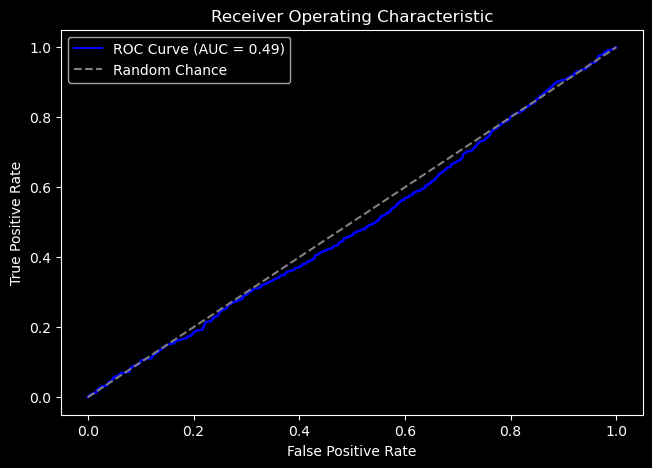

In [13]:
model_bb_fh = train_meta_model(model=rf, features=bb_feat, labels=bb_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_fh.y_test, model_bb_fh.w_test, model_bb_fh.pred, model_bb_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2186
           1       0.07      1.00      0.13       161

    accuracy                           0.07      2347
   macro avg       0.03      0.50      0.06      2347
weighted avg       0.00      0.07      0.01      2347


Confusion Matrix:
[[   0 2186]
 [   0  161]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      2186
           1       0.15      0.68      0.24       161

    accuracy                           0.71      2347
   macro avg       0.56      0.69      0.53      2347
weighted avg       0.91      0.71      0.78      2347


Confusion Matrix:
[[1554  632]
 [  52  109]]


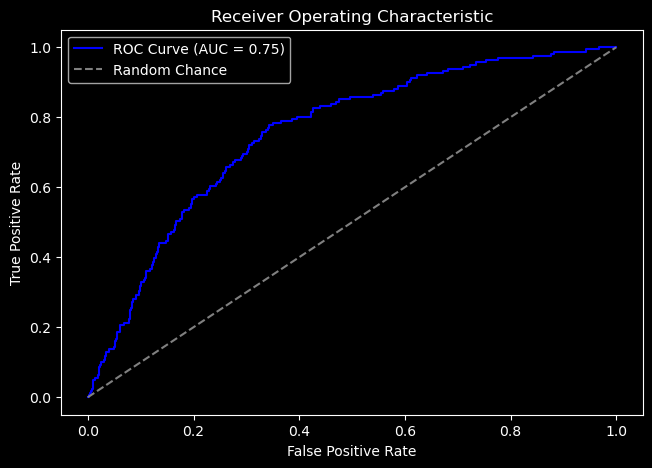

In [14]:
model_bb_tbl = train_meta_model(model=rf, features=bb_feat, labels=bb_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_tbl.y_test, model_bb_tbl.w_test, model_bb_tbl.pred, model_bb_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1572
           1       0.46      1.00      0.63      1337

    accuracy                           0.46      2909
   macro avg       0.23      0.50      0.31      2909
weighted avg       0.21      0.46      0.29      2909


Confusion Matrix:
[[   0 1572]
 [   0 1337]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.86      0.32      0.46      1572
           1       0.54      0.94      0.69      1337

    accuracy                           0.60      2909
   macro avg       0.70      0.63      0.58      2909
weighted avg       0.71      0.60      0.57      2909


Confusion Matrix:
[[ 500 1072]
 [  80 1257]]


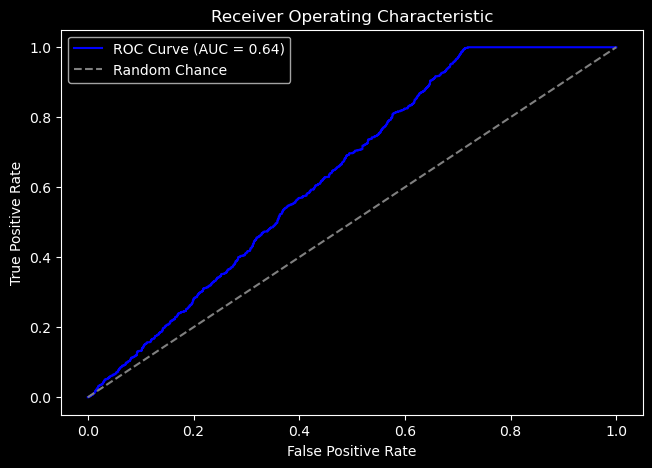

In [15]:
model_bb_trend = train_meta_model(model=rf, features=bb_feat, labels=bb_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend.y_test, model_bb_trend.w_test, model_bb_trend.pred, model_bb_trend.prob, plot_roc=True
    )

Trend-Scanning Mean-Reversion Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2688
           1       0.08      1.00      0.14       221

    accuracy                           0.08      2909
   macro avg       0.04      0.50      0.07      2909
weighted avg       0.01      0.08      0.01      2909


Confusion Matrix:
[[   0 2688]
 [   0  221]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      2688
           1       0.46      0.92      0.61       221

    accuracy                           0.91      2909
   macro avg       0.72      0.92      0.78      2909
weighted avg       0.95      0.91      0.92      2909


Confusion Matrix:
[[2444  244]
 [  17  204]]


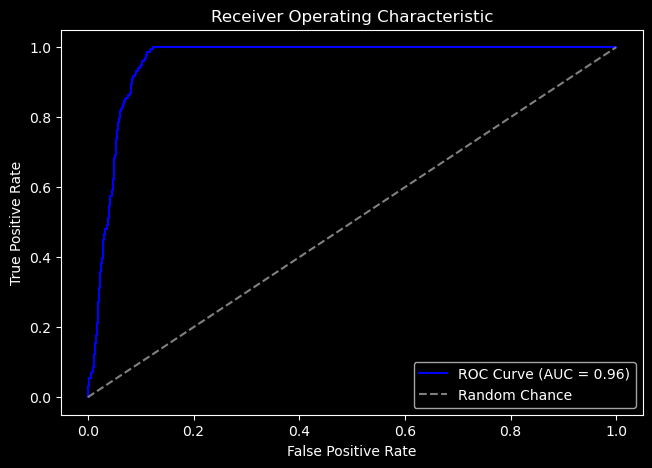

In [16]:
model_bb_trend_mr = train_meta_model(model=rf, features=bb_feat, labels=bb_events_trend_mr)
print("Trend-Scanning Mean-Reversion Meta-Model Results:\n")
meta_labelling_reports(
    model_bb_trend_mr.y_test, model_bb_trend_mr.w_test, model_bb_trend_mr.pred, model_bb_trend_mr.prob, plot_roc=True
    )

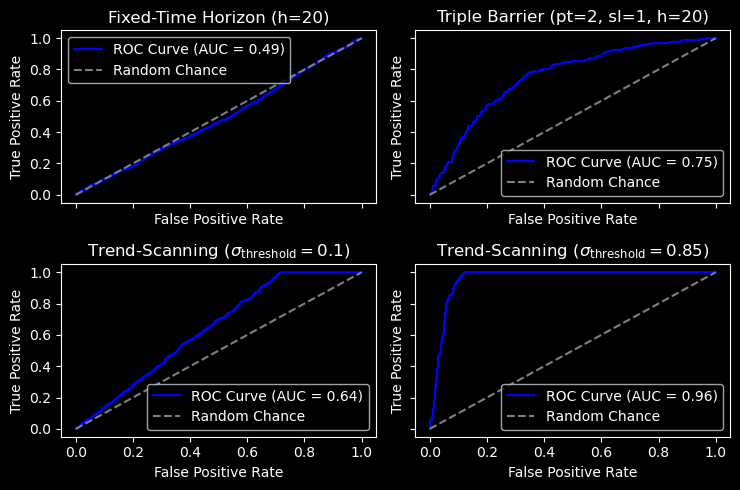

In [51]:
titles = [
    f"Fixed-Time Horizon (h={time_horizon})", 
    f"Triple Barrier (pt={pt_barrier}, sl={sl_barrier}, h={time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
bb_models = [model_bb_fh, model_bb_tbl, model_bb_trend, model_bb_trend_mr]
bb_roc = compare_roc_curves(bb_models, titles)
bb_roc.savefig("reports/bb_roc_comparison.png")

In [18]:
dirpath = "reports"
meta_labelling_classification_reports(model_data=model_bb_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/bb_fixed_time")
meta_labelling_classification_reports(model_data=model_bb_tbl, title="Triple Barrier", output_filename=f"{dirpath}/bb_triple_barrier")
meta_labelling_classification_reports(model_data=model_bb_trend, title=f"Trend-Scanning (σ_threshold={volatility_threshold})", 
                                      output_filename=f"{dirpath}/bb_trend_scanning")
meta_labelling_classification_reports(model_data=model_bb_trend_mr, title=f"Trend-Scanning (σ_threshold={volatility_threshold_mr})", 
                                      output_filename=f"{dirpath}/bb_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1146
           1       0.51      1.00      0.68      1201

    accuracy                           0.51      2347
   macro avg       0.26      0.50      0.34      2347
weighted avg       0.26      0.51      0.35      2347


Confusion Matrix:
[[   0 1146]
 [   0 1201]]

Accuracy:
0.5117170856412442

Successfully generated and saved 'reports/bb_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.48      0.57      0.52      1146
           1       0.50      0.40      0.45      1201

    accuracy                           0.48      2347
   macro avg       0.49      0.49      0.48      2347
weighted avg       0.49      0.48      0.48      2347


Confusion Matrix:
[[653 493]
 [716 485]]

Accuracy:
0.48487430762675754

Successfully generated and saved 'reports/bb_fixe

## 3. Moving Average Crossover Strategy

In [33]:
ma_timeframe = "M30"
tick_bar_size = tick_bar_dict[ma_timeframe]
ma_time_bars, ma_tick_bars = get_data(symbol, ma_timeframe)
bar_size = f"tick-{ma_tick_bars.tick_volume.iloc[0]}"
ma_df = ma_time_bars.loc[sample_start : sample_end]
ma_df0 = ma_tick_bars.loc[sample_start : sample_end]

fast_window, slow_window = 20, 50
ma_strategy = MovingAverageCrossoverStrategy(fast_window, slow_window)
pt_barrier, sl_barrier, time_horizon = (4, 1, 200)
target_vol_params = dict(days=1, lookback=100)
vol_multiplier = 0.5
tb_evaluator = TripleBarrierEvaluator(
    ma_strategy, ma_df, target_vol_params,
    target_vol_multiplier=vol_multiplier,
    filter_events=True,
    vertical_barrier_zero=False,
    )

Loaded EURUSD_M30_tick-1000_2018-01-01-2024-12-31.parq
Loaded EURUSD_M30_time_2018-01-01-2024-12-31.parq
2025-08-31 01:02:40.270 | INFO     | afml.strategies.genetic_optimizer:__init__:147 - Generating primary signals...
2025-08-31 01:02:40.306 | INFO     | afml.strategies.strategies:get_entries:76 - Generated 5,988 trade events generated by CUSUM filter.


### Feature Engineering

In [34]:
# from afml.features.fracdiff import fracdiff_optimal, frac_diff_ffd


# close_ffd, d, _ = fracdiff_optimal(ma_df.close, verbose=True)
# ma_df_ffd = frac_diff_ffd(ma_df, d)

In [42]:
from afml.strategies.ma_crossover_feature_engine import ForexFeatureEngine

feat_engine = ForexFeatureEngine(pair_name=symbol)
ma_feat = feat_engine.calculate_all_features(ma_df)
ma_feat.info()

span = (5, slow_window)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

# bb_feat = create_bollinger_features(ma_df, lookback_window=fast_window, bb_period=20, bb_std=2)

# trend_feat = get_bins_from_trend(ma_df.close, span, volatility_threshold, lookforward=False)
# trend_feat_cols = {k: f"trend_{k}" for k in ['window', 't_value', 'rsquared']}
# trend_feat.rename(columns=trend_feat_cols, inplace=True)
# trend_feat = trend_feat[trend_feat_cols.values()]

# time_feat = get_time_features(ma_df, ma_timeframe, n_terms=3)

# vol_series = ma_df.ta.atr(14)
# fractal_feat = get_fractal_features(ma_df, vol_series, ma_period=fast_window)

# ma_feat = pd.concat([bb_feat, trend_feat, time_feat, fractal_feat], axis=1).shift()
# ma_feat = optimize_dtypes(ma_feat)


# ma_feat["side"] = ma_strategy.generate_signals(ma_df)
# ma_feat.info()

Memory usage reduced from 25.26 MB to 12.76 MB (49.5% reduction)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49280 entries, 2018-01-01 23:30:00 to 2021-12-31 23:00:00
Data columns (total 79 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ma_10                           49280 non-null  float32
 1   ma_20                           49280 non-null  float32
 2   ma_50                           49280 non-null  float32
 3   ma_100                          49280 non-null  float32
 4   ma_200                          49280 non-null  float32
 5   ma_10_20_cross                  49280 non-null  int8   
 6   ma_20_50_cross                  49280 non-null  int8   
 7   ma_50_200_cross                 49280 non-null  int8   
 8   ma_spread_10_20                 49280 non-null  float32
 9   ma_spread_20_50                 49280 non-null  float32
 10  ma_spread_50_200                49280 non-null  float3

### Fixed-Time Horizon Method

In [36]:
ma_events_fh = tb_evaluator.evaluate_performance(0, 0, time_horizon)
ma_events_fh_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_fh)
ma_events_fh_metrics

total_return                           0.898958
annualized_return                      0.174281
volatility                              1.10215
downside_volatility                    0.720549
sharpe_ratio                           1.753298
sortino_ratio                          2.681839
var_95                                -0.015042
cvar_95                               -0.021589
skewness                               0.005453
kurtosis                               2.034684
probabilistic_sharpe_ratio             0.888705
pos_concentration                      0.000265
neg_concentration                      0.000262
time_concentration                     0.003805
max_drawdown                           0.630101
avg_drawdown                           0.310787
drawdown_duration             111 days 21:30:00
ulcer_index                            0.388294
calmar_ratio                           0.276592
num_trades                                 5965
trades_per_year                         

### Triple-Barrier Method

In [37]:
ma_events_tbl = tb_evaluator.evaluate_performance(pt_barrier, sl_barrier, time_horizon)
ma_events_tbl_metrics = tb_evaluator.calculate_strategy_metrics(ma_events_tbl)
ma_events_tbl_metrics

total_return                           1.474122
annualized_return                      0.254751
volatility                             0.474196
downside_volatility                    0.110917
sharpe_ratio                           4.170138
sortino_ratio                         17.828278
var_95                                -0.003761
cvar_95                               -0.004677
skewness                               1.631757
kurtosis                               2.404759
probabilistic_sharpe_ratio             0.998643
pos_concentration                       0.00017
neg_concentration                      0.000052
time_concentration                     0.003776
max_drawdown                           0.450705
avg_drawdown                           0.042786
drawdown_duration              27 days 00:11:07
ulcer_index                             0.08714
calmar_ratio                           0.565229
num_trades                                 5985
trades_per_year                         

In [38]:
print(f"MACrossover_fast{fast_window}_slow{slow_window}: \n")

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    })
ma_metrics_df

MACrossover_fast20_slow50: 



,fixed_horizon,triple_barrier
total_return,0.898958,1.474122
annualized_return,0.174281,0.254751
volatility,1.10215,0.474196
downside_volatility,0.720549,0.110917
sharpe_ratio,1.753298,4.170138
sortino_ratio,2.681839,17.828278
var_95,-0.015042,-0.003761
cvar_95,-0.021589,-0.004677
skewness,0.005453,1.631757
kurtosis,2.034684,2.404759


### Trend-Scanning Method

In [39]:
span = (5, time_horizon)
volatility_threshold = 0.1
volatility_threshold_mr = 0.85

thres = get_daily_vol(ma_df.close).mean() * vol_multiplier
t_events = cusum_filter(ma_df.close, thres)
print(f"t_events: {len(t_events):,}")

side = ma_strategy.generate_signals(ma_df)
close = ma_df.close

ma_events_trend = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold)
ma_events_trend_metrics = calculate_label_metrics(ma_df.index, side, ma_events_trend)

ma_events_trend_mr = get_trend_scanning_meta_labels(close, side, t_events, span, volatility_threshold_mr)
ma_events_trend_metrics_mr = calculate_label_metrics(ma_df.index, side, ma_events_trend_mr)

# ma_events_trend_ffd = get_trend_scanning_meta_labels(close_ffd, side, t_events, span, volatility_threshold, use_log=False)

ma_metrics_df = pd.DataFrame({
    "fixed_horizon": ma_events_fh_metrics,
    "triple_barrier": ma_events_tbl_metrics,
    "trend_scanning": ma_events_trend_metrics,
    "trend_scanning_mr": ma_events_trend_metrics_mr,
    })

print(f"MACrossover_fast{fast_window}_slow{slow_window}:")
print(f"ma_events_trend.shape: {ma_events_trend.shape}\n")
ma_metrics_df

t_events: 5,993
MACrossover_fast20_slow50:
ma_events_trend.shape: (5970, 4)



,fixed_horizon,triple_barrier,trend_scanning,trend_scanning_mr
total_return,0.898958,1.474122,3.986432,4.350765
annualized_return,0.174281,0.254751,0.495156,0.521786
volatility,1.10215,0.474196,1.156369,0.814459
downside_volatility,0.720549,0.110917,0.724708,0.69635
sharpe_ratio,1.753298,4.170138,3.447821,4.660319
sortino_ratio,2.681839,17.828278,5.501458,5.450762
var_95,-0.015042,-0.003761,-0.015248,-0.007755
cvar_95,-0.021589,-0.004677,-0.022259,-0.018975
skewness,0.005453,1.631757,-0.026077,0.045441
kurtosis,2.034684,2.404759,1.466651,11.430065


### Random Forest

In [40]:
random_state = 40
min_w_leaf = 0.05

rf = RandomForestClassifier(
    criterion='entropy',
    n_estimators=1000,
    class_weight='balanced_subsample',
    random_state=random_state,
    min_weight_fraction_leaf=min_w_leaf,
    n_jobs=-1,  # Use all available cores
    )

Fixed-Time Horizon Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       878
           1       0.51      1.00      0.67       911

    accuracy                           0.51      1789
   macro avg       0.25      0.50      0.34      1789
weighted avg       0.26      0.51      0.34      1789


Confusion Matrix:
[[  0 878]
 [  0 911]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       878
           1       0.53      0.30      0.38       911

    accuracy                           0.51      1789
   macro avg       0.51      0.51      0.49      1789
weighted avg       0.51      0.51      0.48      1789


Confusion Matrix:
[[637 241]
 [640 271]]


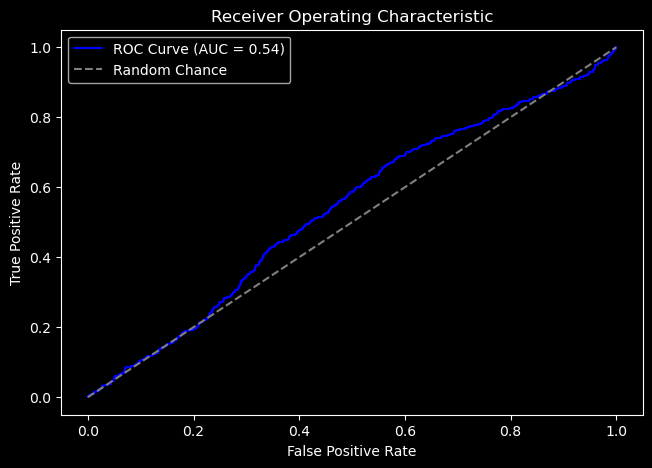

In [43]:
model_ma_fh = train_meta_model(model=rf, features=ma_feat, labels=ma_events_fh)
print("Fixed-Time Horizon Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_fh.y_test, model_ma_fh.w_test, model_ma_fh.pred, model_ma_fh.prob, plot_roc=True
    )

Triple Barrier Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1383
           1       0.23      1.00      0.37       412

    accuracy                           0.23      1795
   macro avg       0.11      0.50      0.19      1795
weighted avg       0.05      0.23      0.09      1795


Confusion Matrix:
[[   0 1383]
 [   0  412]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.77      0.99      0.87      1383
           1       0.48      0.02      0.05       412

    accuracy                           0.77      1795
   macro avg       0.62      0.51      0.46      1795
weighted avg       0.71      0.77      0.68      1795


Confusion Matrix:
[[1372   11]
 [ 402   10]]


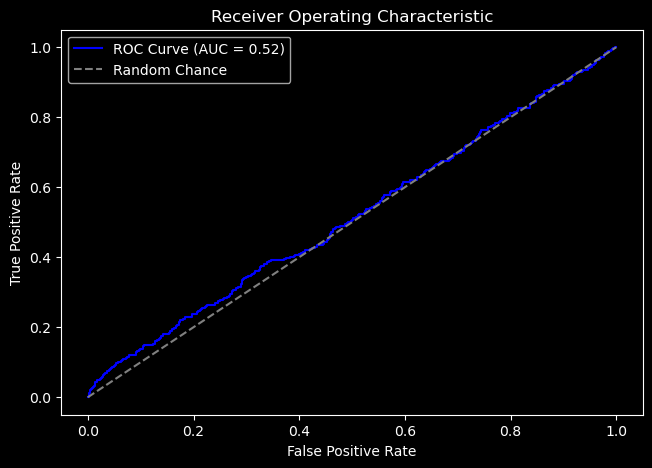

In [44]:
model_ma_tbl = train_meta_model(model=rf, features=ma_feat, labels=ma_events_tbl)
print("Triple Barrier Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_tbl.y_test, model_ma_tbl.w_test, model_ma_tbl.pred, model_ma_tbl.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       981
           1       0.45      1.00      0.62       809

    accuracy                           0.45      1790
   macro avg       0.23      0.50      0.31      1790
weighted avg       0.20      0.45      0.28      1790


Confusion Matrix:
[[  0 981]
 [  0 809]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.58      0.79      0.67       981
           1       0.54      0.30      0.39       809

    accuracy                           0.57      1790
   macro avg       0.56      0.55      0.53      1790
weighted avg       0.56      0.57      0.54      1790


Confusion Matrix:
[[777 204]
 [566 243]]


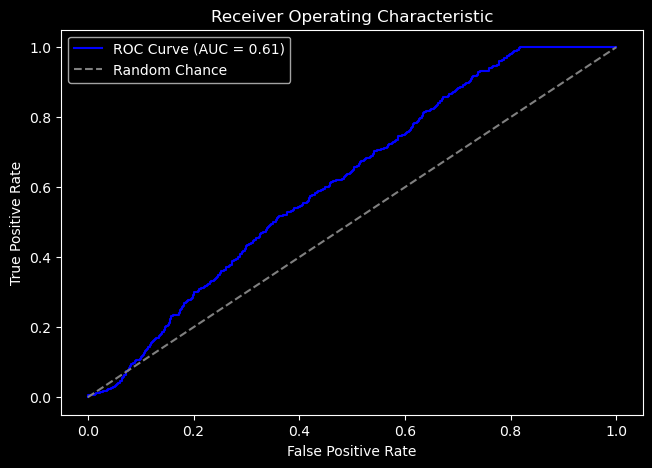

In [45]:
model_ma_trend = train_meta_model(model=rf, features=ma_feat, labels=ma_events_trend)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend.y_test, model_ma_trend.w_test, model_ma_trend.pred, model_ma_trend.prob, plot_roc=True
    )

Trend-Scanning Meta-Model Results:

Primary-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1707
           1       0.05      1.00      0.09        83

    accuracy                           0.05      1790
   macro avg       0.02      0.50      0.04      1790
weighted avg       0.00      0.05      0.00      1790


Confusion Matrix:
[[   0 1707]
 [   0   83]]

Meta-Model on Validation Set:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1707
           1       0.16      0.13      0.15        83

    accuracy                           0.93      1790
   macro avg       0.56      0.55      0.55      1790
weighted avg       0.92      0.93      0.92      1790


Confusion Matrix:
[[1651   56]
 [  72   11]]


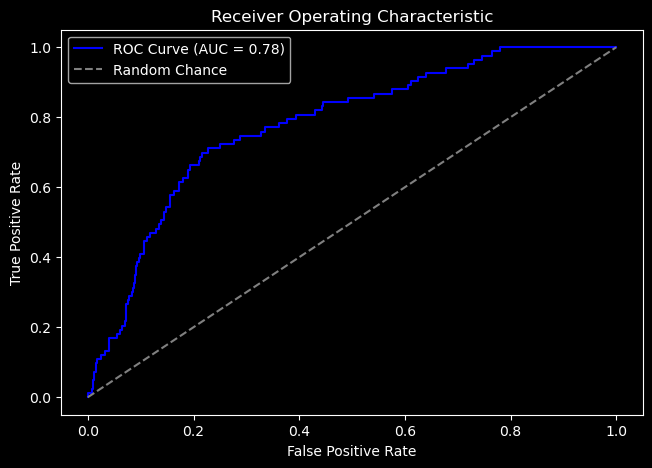

In [46]:
model_ma_trend_mr = train_meta_model(model=rf, features=ma_feat, labels=ma_events_trend_mr)
print("Trend-Scanning Meta-Model Results:\n")
meta_labelling_reports(
    model_ma_trend_mr.y_test, model_ma_trend_mr.w_test, model_ma_trend_mr.pred, model_ma_trend_mr.prob, plot_roc=True
    )

In [47]:
dirpath = "reports"
meta_labelling_classification_reports(model_data=model_ma_fh, title="Fixed-Time Horizon", output_filename=f"{dirpath}/ma_fixed_time")
meta_labelling_classification_reports(model_data=model_ma_tbl, title="Triple Barrier", output_filename=f"{dirpath}/ma_triple_barrier")
meta_labelling_classification_reports(model_data=model_ma_trend, title=f"Trend-Scanning (σ_threshold={volatility_threshold})", 
                                      output_filename=f"{dirpath}/ma_trend_scanning")
meta_labelling_classification_reports(model_data=model_ma_trend_mr, title=f"Trend-Scanning (σ_threshold={volatility_threshold_mr})", 
                                      output_filename=f"{dirpath}/ma_trend_scanning_mr")

Classification Report (as text):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       878
           1       0.51      1.00      0.67       911

    accuracy                           0.51      1789
   macro avg       0.25      0.50      0.34      1789
weighted avg       0.26      0.51      0.34      1789


Confusion Matrix:
[[  0 878]
 [  0 911]]

Accuracy:
0.5092230296254892

Successfully generated and saved 'reports/ma_fixed_time_primary_clf_report.png'
Classification Report (as text):
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       878
           1       0.53      0.30      0.38       911

    accuracy                           0.51      1789
   macro avg       0.51      0.51      0.49      1789
weighted avg       0.51      0.51      0.48      1789


Confusion Matrix:
[[637 241]
 [640 271]]

Accuracy:
0.5075461151481274

Successfully generated and saved 'reports/ma_fixed_tim

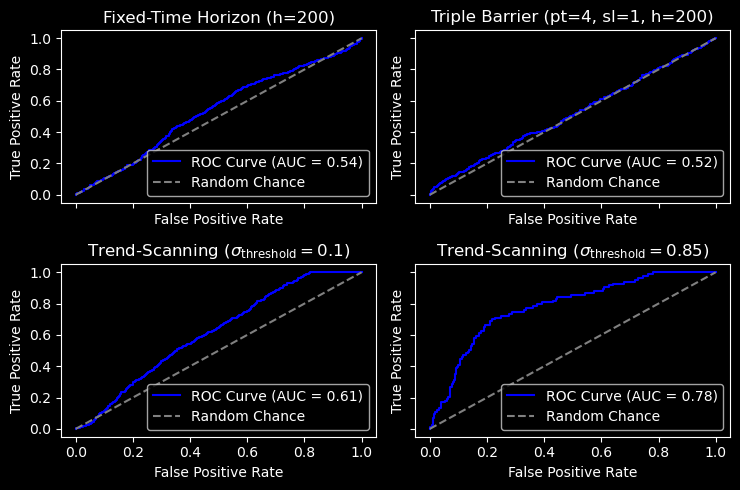

In [49]:
titles = [
    f"Fixed-Time Horizon (h={time_horizon})", 
    f"Triple Barrier (pt={pt_barrier}, sl={sl_barrier}, h={time_horizon})", 
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold}$)",
    f"Trend-Scanning ($\\sigma_{{\\text{{threshold}}}} = {volatility_threshold_mr}$)",
    ]
ma_models = [model_ma_fh, model_ma_tbl, model_ma_trend, model_ma_trend_mr]
ma_roc = compare_roc_curves(ma_models, titles)
ma_roc.savefig("reports/ma_roc_comparison.png")